In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import birdsonganalysis as bsa
from copy import deepcopy
from os.path import join
import json
import pandas as pd
import pickle
from syllable_cluster import extract_syllables_feature, percentage_change, all_syllables_features

import sys

sys.path.append('../model')

from song_model import SongModel

sns.set_palette('colorblind')
%matplotlib inline

In [31]:
path = '../model/res/super_concurrent_170419_152612/10_conc+slow_dev+default_coef+big_ba+5_replay+on_alpha_silence_beta'
print(path)
with open(join(path, 'data_cur.pkl'), 'rb') as f:
    data = pickle.load(f)

../model/res/super_concurrent_170419_152612/10_conc+slow_dev+default_coef+big_ba+5_replay+on_alpha_silence_beta


In [32]:
root_data = [item[1] for item in data if item[0] == 'root']
rd = pd.DataFrame(root_data)
len(rd)

99

In [33]:
sm = rd.iloc[-1]['songs'][5]

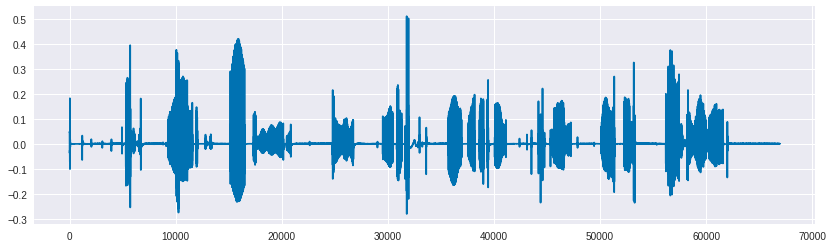

In [34]:
plt.figure(figsize=(14, 4))
plt.plot(sm.gen_sound())
plt.show()

In [35]:
from IPython.display import Audio

Audio(sm.gen_sound(), rate=44100)

11


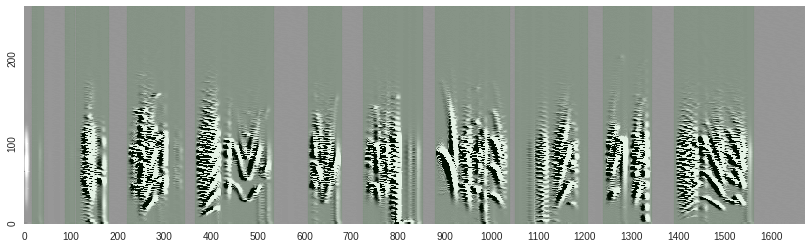

In [36]:
syllables_data = extract_syllables_feature(sm.gen_sound())
fig = plt.figure(figsize=(14, 4))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(bsa.spectral_derivs(sm.gen_sound(), freq_range=256, fft_step=40, fft_size=1024), contrast=0.01, ax=ax)
print(len(syllables_data))
for syllable in syllables_data:
    ax.axvspan(syllable['beg'], syllable['end'], color='g', alpha=0.1)

In [37]:
print(path)

../model/res/super_concurrent_170419_152612/10_conc+slow_dev+default_coef+big_ba+5_replay+on_alpha_silence_beta


In [41]:
from ipywidgets.widgets import FloatProgress
from IPython.display import display
progress = FloatProgress(min=0, max=1)
display(progress)
force = True
try:
    if force:
        raise Exception('Force regen')
    load = pd.HDFStore(join(path, 'syllables.hd5'))
    all_dat_10 = load['syllables']
    progress.value = 1
except Exception as e:
    print(e)
    print(type(e))
    all_dat_10 = all_syllables_features(rd, progress)
    all_dat_10.to_hdf(join(path, 'syllables.hd5'), 'syllables')

Force regen
<class 'Exception'>


In [40]:
all_dat_10

,beg,comb,day,end,isong,isyb,length,mam,mamplitude,mentropy,mfm,mgoodness,moment,mpitch,vam,vamplitude,ventropy,vfm,vgoodness,vpitch
0,129,0.5,0,180,0,0,51,-1.572266e-04,-0.790033,-0.960722,-0.031341,-0.912991,evening,-0.974802,0.587322,0.810908,0.301032,2.688950,0.803555,2.021109e+00
1,212,0.5,0,245,0,1,33,-1.898215e-04,-0.448935,-0.435286,-0.371340,1.160619,evening,0.251162,3.997308,0.578012,0.166251,2.825067,4.184746,2.692824e+00
2,266,0.5,0,292,0,2,26,3.136137e-05,-2.126593,0.658506,0.204843,-3.041616,evening,-5.167764,0.023341,0.236522,0.185614,3.609520,1.172424,1.353493e+00
3,366,0.5,0,403,0,3,37,-2.891581e-04,-1.622552,-0.302300,-0.179384,-0.232428,evening,0.691143,0.141873,0.665413,0.260231,2.381614,1.477548,2.173595e-03
4,434,0.5,0,459,0,4,25,-3.947725e-05,-2.493548,0.835066,0.175285,-3.074523,evening,0.854621,0.006699,0.148318,0.163831,3.560447,0.952071,9.671974e-03
5,742,0.5,0,793,0,5,51,-5.799843e-04,0.211112,-0.380965,-0.136841,0.277110,evening,0.638038,8.485814,0.628872,0.082415,2.086135,2.781228,7.298196e-01
6,825,0.5,0,849,0,6,24,-1.135692e-04,-3.078797,0.970417,0.048707,-3.305086,evening,0.616494,0.001052,0.103766,0.135644,3.436799,0.489258,1.574582e+00
7,878,0.5,0,961,0,7,83,-2.059829e-04,-0.712196,-0.293497,-0.486758,0.071246,evening,0.671010,0.541022,0.255012,0.129384,1.899105,4.821909,4.518158e-01
8,992,0.5,0,1017,0,8,25,-2.073613e-04,-2.190834,0.634546,0.095601,-3.115401,evening,0.586131,0.016513,0.149881,0.186944,3.389774,0.939040,1.493783e+00
9,1048,0.5,0,1072,0,9,24,-3.399284e-05,-3.016332,1.013894,0.046816,-3.430411,evening,-5.400449,0.001290,0.103231,0.135376,3.321374,0.278053,8.710282e-08


In [44]:
first_day = 5
last_day = first_day + 1
plot_dat = all_dat_10[((all_dat_10.day == first_day) & (all_dat_10.moment == 'evening') & (all_dat_10.isyb == 1))
                   | ((all_dat_10['day'] == last_day) & (all_dat_10['moment'] == 'morning')  & (all_dat_10.isyb == 1))]

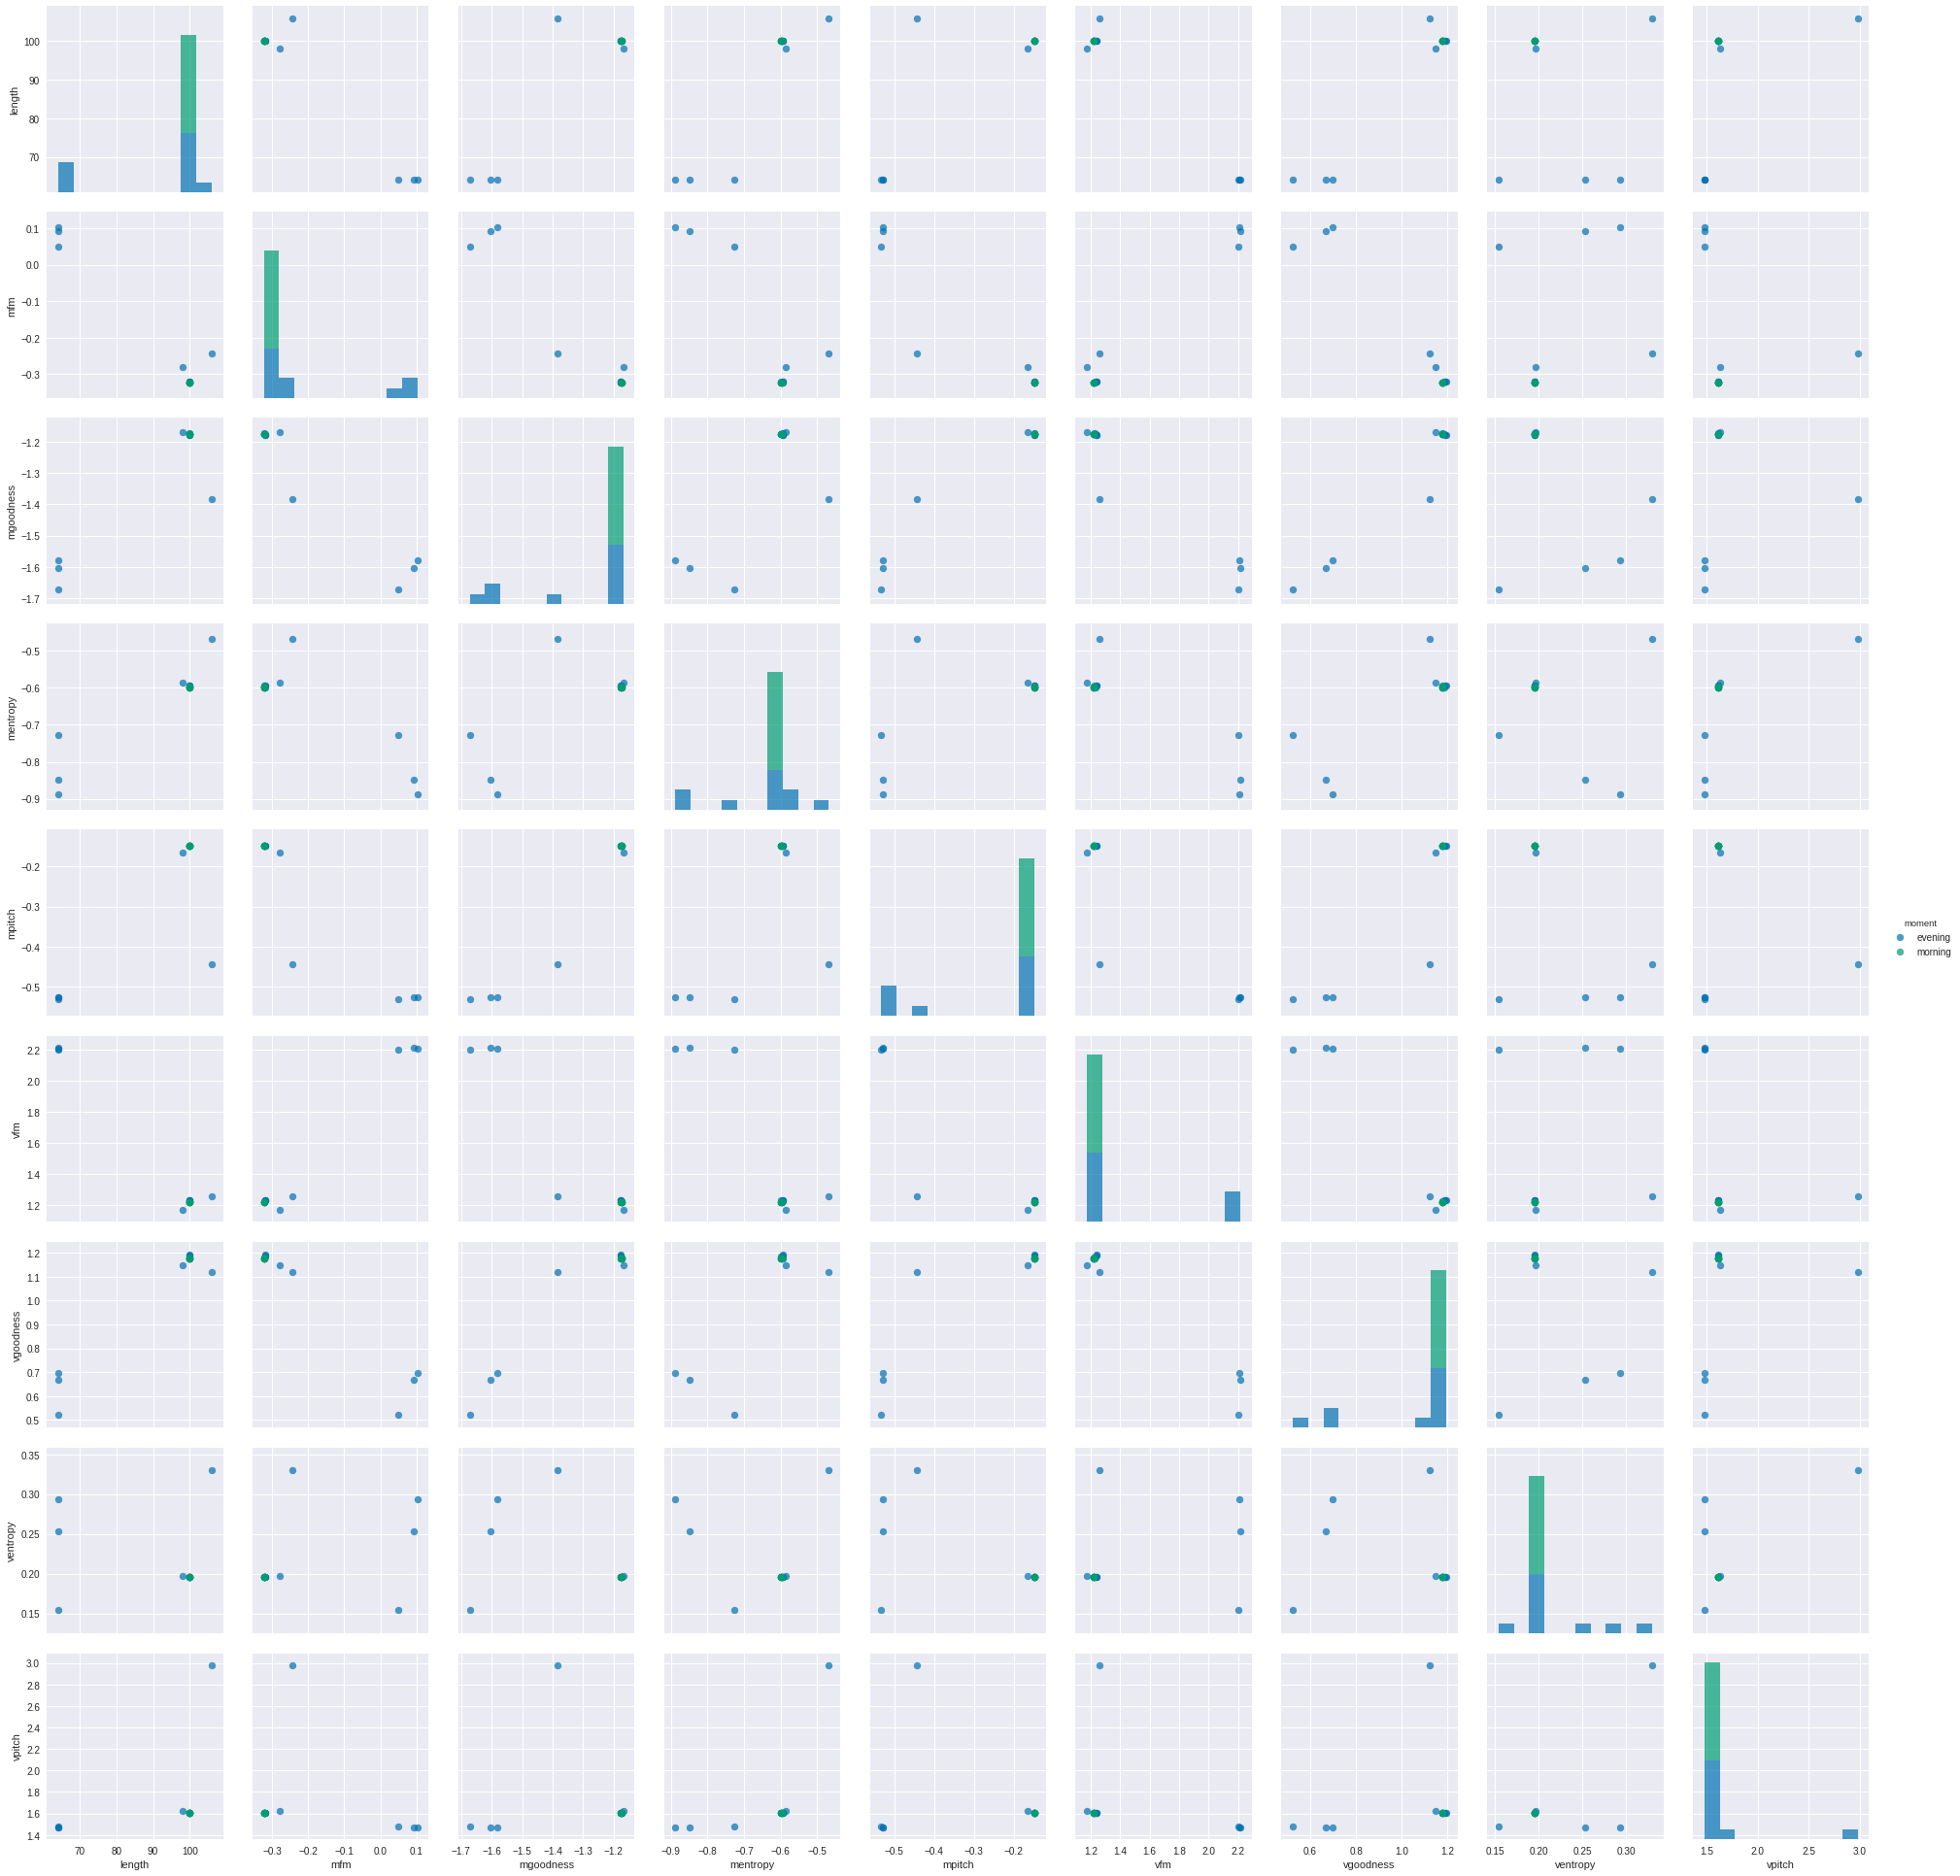

In [45]:
g = sns.PairGrid(plot_dat, hue="moment", vars=['length', 'mfm', 'mgoodness', 'mentropy', 'mpitch',
                                            'vfm', 'vgoodness', 'ventropy', 'vpitch'], size=3)
g.map_diag(plt.hist, alpha=0.7)
g.map_offdiag(plt.scatter, alpha=0.7)
g.add_legend()

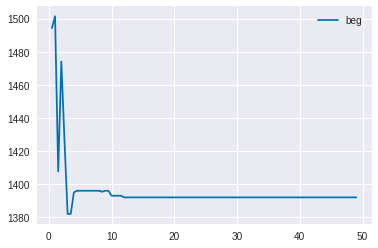

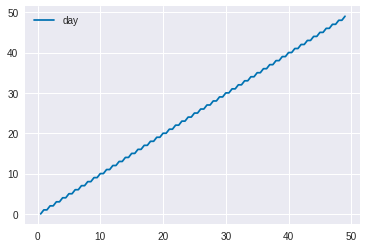

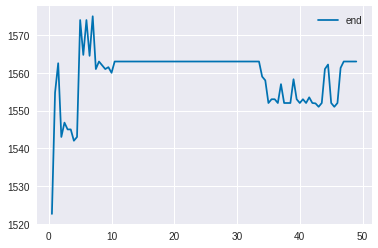

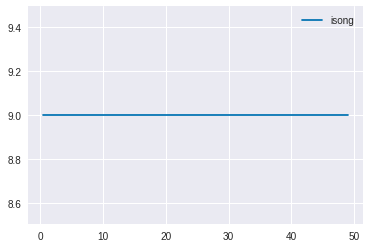

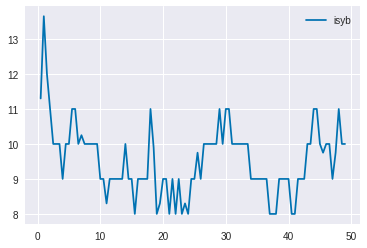

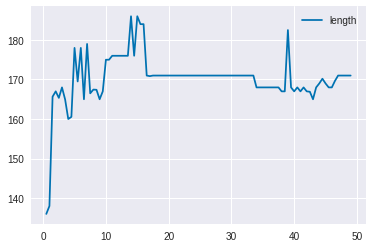

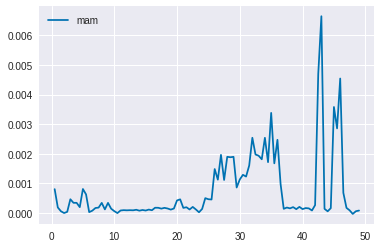

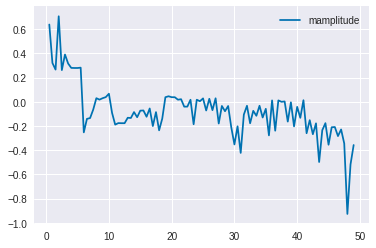

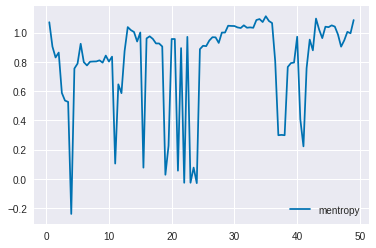

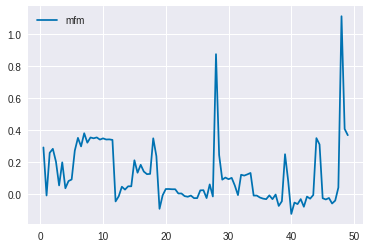

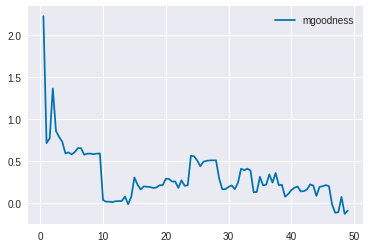

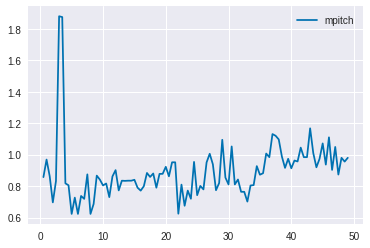

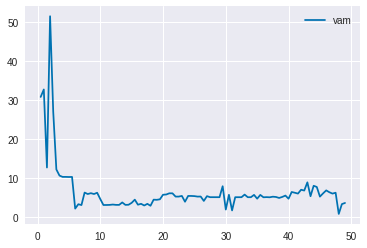

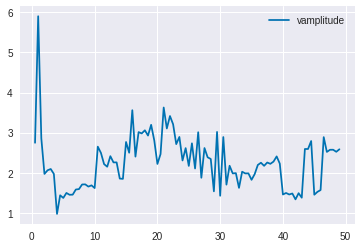

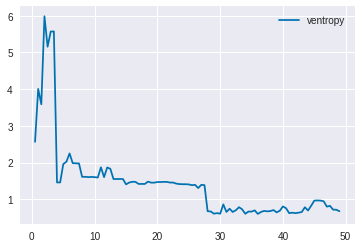

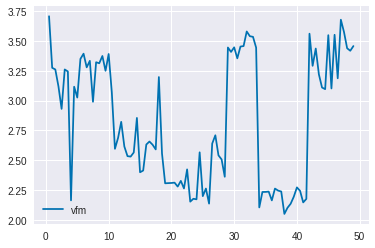

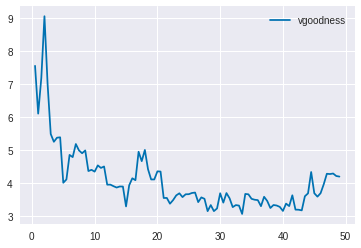

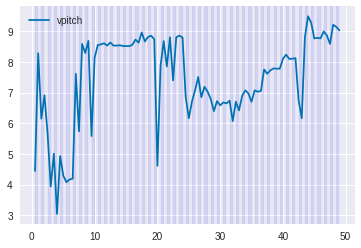

In [67]:
plt.figure(figsize=(14, 14))
med = all_dat_10.groupby('comb').quantile(0.95)
for item in med.keys():
    plt.figure()
    plt.plot(med[item], label=item)
    plt.legend()
for day in range(np.max(all_dat['day'])):
    plt.axvspan(day+0.5, day+1, color='b', alpha=0.1)

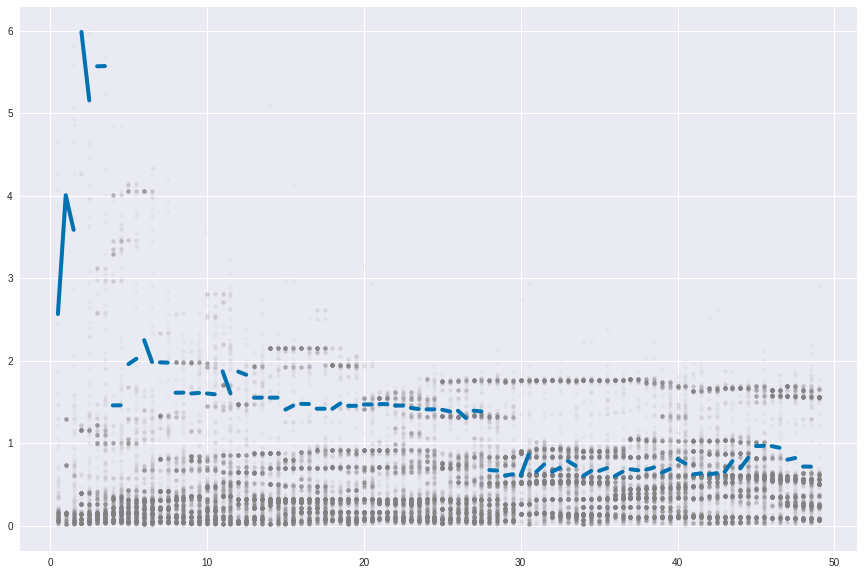

In [59]:
plt.figure(figsize=(15, 10))

feat = 'ventropy'

splitted = all_dat_10.groupby('comb')[feat].quantile(0.95)
for i in splitted.index:
    if i % 1 == 0:
        splitted.set_value(i + 0.75, np.nan)
splitted.sort_index(inplace=True)


plt.scatter(all_dat['comb'], all_dat[feat], marker='.', alpha=0.05, color="grey")
plt.plot(splitted, linewidth=4)

(0, 100)

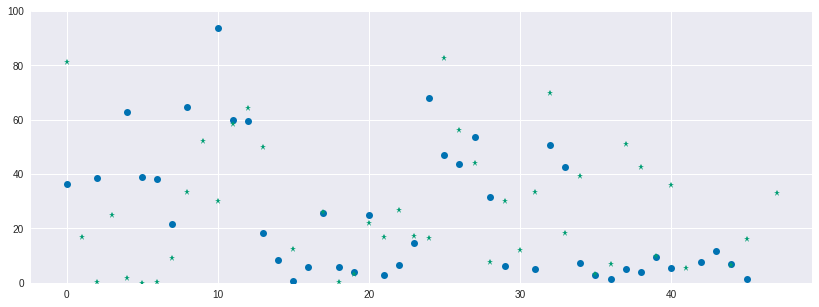

In [55]:
means = []
for day in range(1, np.max(all_dat['day']) + 1):
    before_night = all_dat[((all_dat.day == day) & (all_dat.moment == 'evening') & (all_dat.isyb == 1))]
    after_night = all_dat[((all_dat.day == day + 1) & (all_dat.moment == 'morning') & (all_dat.isyb == 1))]
    data = percentage_change(before_night, after_night)
    
    mean = np.mean((data['mentropy'], data['mfm'], data['mgoodness'], data['vfm'], data['ventropy'],
                    data['vgoodness']))
    means.append(mean)
means = np.array(means)
means_10 = []
for day in range(1, np.max(all_dat_10['day']) + 1):
    before_night = all_dat_10[((all_dat_10.day == day) & (all_dat_10.moment == 'evening') & (all_dat_10.isyb == 1))]
    after_night = all_dat_10[((all_dat_10.day == day + 1) & (all_dat_10.moment == 'morning') & (all_dat_10.isyb == 1))]
    data = percentage_change(before_night, after_night)
    
    mean = np.mean((data['mentropy'], data['mfm'], data['mgoodness'], data['vfm'], data['ventropy'],
                    data['vgoodness']))
    means_10.append(mean)
    
means_10 = np.array(means_10)
plt.figure(figsize=(14, 5))
plt.plot(means, 'o')
plt.plot(means_10, '*')
plt.ylim((0,100))



In [25]:
all_dat

,beg,comb,day,end,isong,isyb,length,mam,mamplitude,mentropy,mfm,mgoodness,moment,mpitch,vam,vamplitude,ventropy,vfm,vgoodness,vpitch
0,378,0.5,0,431,0,0,53,-0.000349,0.406233,-0.892685,-0.330595,1.224699,evening,0.589464,52.104347,1.186085,0.526777,2.004648,8.746432,7.187098e-01
1,992,0.5,0,1016,0,1,24,0.000209,-2.437779,0.824960,0.251884,-3.216733,evening,0.594819,0.007202,0.107708,0.141242,3.452897,0.747247,1.563257e+00
2,1052,0.5,0,1068,0,2,16,0.000227,-3.247628,1.209245,0.330109,-3.635995,evening,-5.400358,0.000508,0.002392,0.032483,2.809216,0.005663,9.262796e-15
3,1494,0.5,0,1539,0,3,45,-0.001078,0.130676,-0.559016,-0.490549,-0.319878,evening,0.521120,17.766970,0.935130,0.365600,2.423520,2.886785,1.633064e+00
4,601,0.5,0,627,1,0,26,0.000152,-1.077894,0.694300,-0.040877,-3.024846,evening,-5.098905,0.512553,0.207874,0.164997,3.283850,0.336511,1.566854e+00
5,657,0.5,0,682,1,1,25,-0.000199,-2.049943,0.902909,-0.313259,-2.654894,evening,-5.139877,0.024746,0.139807,0.106101,2.776918,0.309908,1.629465e+00
6,713,0.5,0,738,1,2,25,-0.000102,-3.047573,0.807901,-0.375348,-2.700765,evening,-5.400535,0.001246,0.132958,0.073992,1.992372,0.147541,1.541724e-07
7,824,0.5,0,850,1,3,26,0.000513,-0.762622,0.779104,0.089803,-3.008103,evening,-5.111524,1.321452,0.211162,0.179827,3.511304,0.607125,1.479360e+00
8,880,0.5,0,906,1,4,26,-0.000215,-1.989995,0.939957,-0.168586,-2.959929,evening,-5.076722,0.035769,0.253021,0.169274,2.796732,0.178903,1.798285e+00
9,936,0.5,0,961,1,5,25,0.000078,-1.533275,0.839028,-0.077001,-3.228193,evening,0.590922,0.117009,0.147366,0.159703,3.085537,0.251606,1.496696e+00
